## Bees and Ants Classification using VGG16

Transfer learning used in cases:

    > Where we donot use the enough labels 
    
    > There are effective pretrained models already!!

Implementing:
    pytorch contains the pretraind  data models already
    like AlexNet, VGG16

we dont touch  the Conv parameters of the pre trained models. We only use few of the layers and  bypass the other to maintain the time to train as well as sophisitication

In [9]:
import torch
from torchvision import datasets, transforms, models ##contains transformations to apply on these images before supplying to the nn
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [10]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
! git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [12]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                               transforms.RandomRotation(10), #angle
                               transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),#params= rotation= as we've  already  set 10, so set 0 here, shear level, zoom 
                               transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))#here the first tuple, to normalize all channel with means of, second is SD
                               ])## ToTensor converts the image to the tensor and characterizes the image as

transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))#here the first tuple, to normalize all channel with means of, second is SD
                               ])## ToTensor converts the image to the tensor and characterizes the image as
                                    ##Channel (C), Height (H), Width(W)
    ## using the values -1, 1 reduces the skewness of the data, hence we apply the normalizations

    
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)#reduced  batch size. it is used the epoch accuracy later.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 4, shuffle=False)

In [13]:
print(len(training_dataset))
len(validation_dataset)
#as we're training over the pretrained model, we donont need to use the larger datas. This is enough

244


153

In [14]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy() #first dim= color, second= width, third =height, we know that in MNIST= it is (1, 28, 28)
#but, to plot our image, we need (28, 28, 1). So, Transform it.
    image= image.transpose(1, 2, 0) #swap axis 0 to 1 and 1 to 2 and 2 to 0
#normalizaion = Z= (x-mean)/SD. So, we do this:
    
    image =image*np.array((0.5, 0.5, 0.5))+ np.array((0.5, 0.5, 0.5))
    image=image.clip(0, 1) #to ensure the values are in betn 0 and 1
    return image

In [15]:
classes=['ant', 'bee']#order  is important. ant- class1 bees- class2

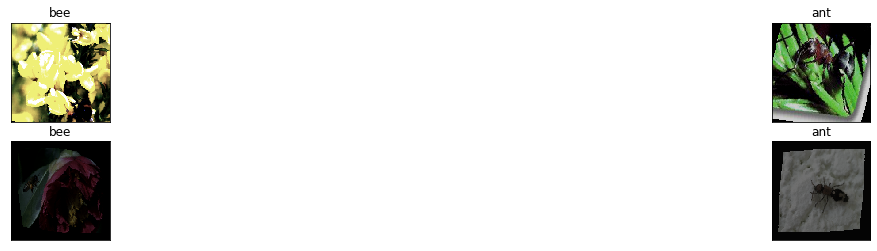

In [16]:
dataiter = iter(training_loader)
images, labels = dataiter.next()#grabs first batch of training data
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title(classes[labels[idx].item()])

# USING VGG16

In [17]:
model=models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
#now, we have to freeze the parameters in the model
for param in model.features.parameters():
    param.requires_grad=False #this will freeze the gradients in the models already trained
    #now, as  there are only 2 classes ants  and bees, we add another 2 layers of dense layers of FCNNS

In [19]:
import torch.nn as nn
# alex net contains seqntial layers.. so,, hence, we need to access the sixth element of the classifier and retrive te output elements in that layer
n_inputs=model.classifier[6].in_features #here, 4096 inputs recieved  in this layer this can be put into new layer
last_layer=nn.Linear(n_inputs, len(classes))
model.classifier[6]=last_layer

model.to(device) #moving the pretraind  model to the GPU
print(model)#see the change in layer 6

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
#edited  after copying the old MNIST code here...
epochs=10
running_loss_history=[]
running_corrects_history=[]
val_running_loss_history=[]
val_running_corrects_history=[]


for e in range(epochs):
    running_loss=0.0
    running_corrects=0.0
    val_running_loss=0.0
    val_running_corrects=0.0

    for inputs, labels in training_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
#         inputs=inputs.view(inputs.shape[0], -1) No need to flatten as we're passing them to CNN first instead of FCNN
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds=torch.max(outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
        running_loss+=loss.item()#add up to batch iteration
        running_corrects+=torch.sum(preds==labels.data)
        
    ## after every epoch, validate using test set
    else:
        with torch.no_grad():#sets requires_grad flag to false as it is not needed here and saves the memory.
            for val_inputs, val_labels in validation_loader:
                val_inputs=val_inputs.to(device)
                val_labels=val_labels.to(device)
#                 val_inputs=val_inputs.view(val_inputs.shape[0], -1)
                val_outputs=model(val_inputs)
                val_loss=criterion(val_outputs, val_labels)                
                _, val_preds=torch.max(val_outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
                val_running_loss+=val_loss.item()#add up to batch iteration
                val_running_corrects+=torch.sum(val_preds==val_labels.data)
        
        epoch_loss=(running_loss)/len(training_loader.dataset)#here, the length of dataset, can be used to find out probability to increase the efficiency
        epoch_acc= (running_corrects.float())/len(training_loader.dataset)#if we change the batch  size, we  have to make this adjustment
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        print("EPOCH: ", e+1)
        print('training loss: {:.4f}, Train Accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss=(val_running_loss)/len(validation_loader.dataset)
        val_epoch_acc= (val_running_corrects.float())/len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Validation loss: {:.4f}, Validation Accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

EPOCH:  1
training loss: 0.1455, Train Accuracy 0.7090
Validation loss: 0.0677, Validation Accuracy 0.9216
EPOCH:  2
training loss: 0.0840, Train Accuracy 0.8238
Validation loss: 0.1354, Validation Accuracy 0.8693
EPOCH:  3
training loss: 0.0876, Train Accuracy 0.8320
Validation loss: 0.0931, Validation Accuracy 0.8758
EPOCH:  4
training loss: 0.0758, Train Accuracy 0.8525
Validation loss: 0.1086, Validation Accuracy 0.9150
EPOCH:  5
training loss: 0.0698, Train Accuracy 0.8811
Validation loss: 0.1046, Validation Accuracy 0.9085
EPOCH:  6
training loss: 0.0467, Train Accuracy 0.9180
Validation loss: 0.1506, Validation Accuracy 0.8954
EPOCH:  7
training loss: 0.0839, Train Accuracy 0.8811
Validation loss: 0.1502, Validation Accuracy 0.8954
EPOCH:  8
training loss: 0.0469, Train Accuracy 0.9221
Validation loss: 0.1629, Validation Accuracy 0.9085
EPOCH:  9
training loss: 0.0880, Train Accuracy 0.8443
Validation loss: 0.1865, Validation Accuracy 0.8824
EPOCH:  10
training loss: 0.0637, Tra

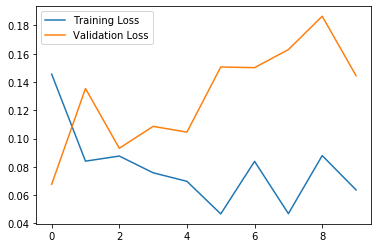

In [22]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

###### NOTE: here, there are the values from 0 to 1 because we've change the calculation , methodology of the epoch accuracy and losses by introduction of the datasetsize.

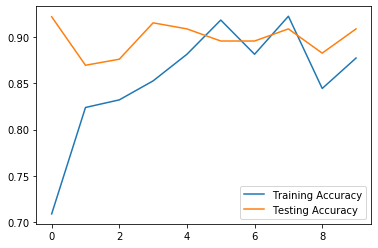

In [23]:
plt.plot(running_corrects_history, label="Training Accuracy")
plt.plot(val_running_corrects_history, label="Testing Accuracy")
plt.legend()

#### Testing the images from the web

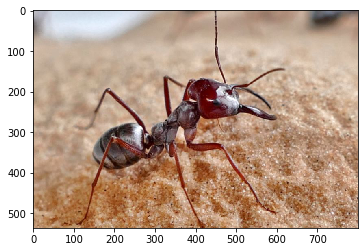

In [24]:
#testing using the images in the web
import requests
from PIL import Image
import PIL.ImageOps
url='https://cdn.arstechnica.net/wp-content/uploads/2019/10/fastant1-800x536.jpg'
response=requests.get(url, stream=True)
img=Image.open(response.raw)
plt.imshow(img)

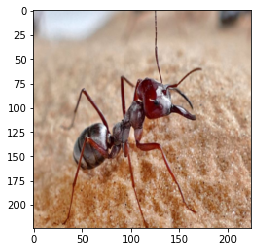

In [25]:
#preprocess it 
img=transform(img) #from the fun declared earlier in the beginning
plt.imshow(im_convert(img))

In [26]:
#now, feed it to the  nn.
img=img.to(device).unsqueeze(0)
# image=img[0].unsqueeze(0).unsqueeze(0)# to add the extra dim
output=model(img)
_, pred=torch.max(output, 1)
print(classes[pred.item()])

ant


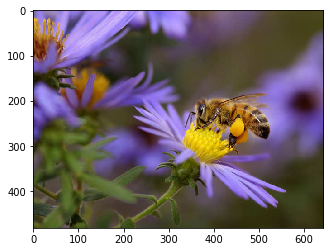

In [27]:
#testing using the images in the web
import requests
from PIL import Image
import PIL.ImageOps
url='https://img.etimg.com/thumb/msid-71367762,width-643,imgsize-581705,resizemode-4/istock-146954964.jpg'
response=requests.get(url, stream=True)
img=Image.open(response.raw)
plt.imshow(img)

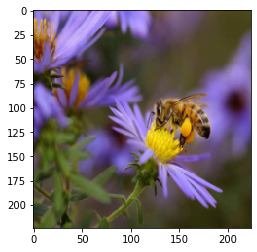

In [28]:
#preprocess it 
img=transform(img) #from the fun declared earlier in the beginning
plt.imshow(im_convert(img))

In [29]:
#now, feed it to the  nn.
img=img.to(device).unsqueeze(0)
# image=img[0].unsqueeze(0).unsqueeze(0)# to add the extra dim
output=model(img)
_, pred=torch.max(output, 1)
print(classes[pred.item()])

bee


## IT TURNS OUT TO WORK WELL!!!! 

###### running on the validation images

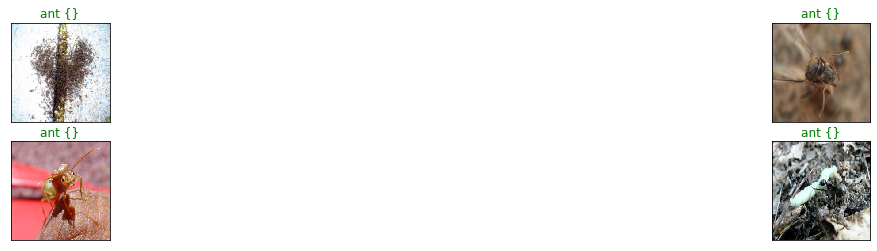

In [31]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()#grabs first batch of training data

images_=images.to(device)
labels=labels.to(device)

output=model(images_)
_, preds=torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title("{} {{}}".format(str(classes[preds[idx].item()]), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))